<a href="https://colab.research.google.com/github/Viggy1357/datasciencehackathonBankEvie/blob/main/YME_Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")  #using style ggplot
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
import tensorflow_hub as hub

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,mean_squared_error
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import RandomFourierFeatures

# **Step 1 :Cleaning and Data Prepping**

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/loandefault_5k.csv")
df.head()

In [ ]:
df.info()

we can observe this datasets has 5000 rows full with data (without any missing values in any of the cells) - thus do not require to perform mean average to fill up the empty cells. 

we also observe it has 23 features, with the last column being the actual output data(Y) of defaulters. 

Columns PAY_0, PAY_2 ... PAY_6 indicates the repayment status with no PAY_1 column, so we rename PAY_0 to PAY_1 and default payment next month to Y, for ease of understanding, 

In [ ]:
df.rename(columns={'default payment next month':'Y'}, inplace=True)
df.rename(columns={'PAY_0':'PAY_1'}, inplace=True)

In [ ]:
df.isna().sum()    # check for missing values for surity

there's no missing values hence no cleaning is required as it's already cleaned. Next, we'll move on to data visualization.

# **Step 2: Data Visualization**

In [ ]:
# Checking data balance/proportion
loan = df.Y.value_counts().to_frame().rename(columns={"Y":"absolute"})
loan["percent"] = (loan.apply(lambda x: x/x.sum()*100).round(2))
display(loan)


# pie chart
df.Y.value_counts().plot(kind='pie', subplots=True, autopct='%1.2f%%', explode= (0.05, 0.05), startangle=80, legend=True, fontsize=14, figsize=(16,8), textprops={'color':"black"})
plt.legend(["0: paid loan","1: not paid loan"])

here we notice that the data set we have is an unbalanced datasets where the non-loan defaulters are 3x the amount of loan defaulters.

In [ ]:
plt.subplots(figsize=(30,20))
sns.heatmap(df.corr(), annot=True)
plt.show()

In [ ]:
mask = np.triu(df.corr(), 1)
plt.figure(figsize=(30, 20))
sns.heatmap(df.corr(), annot=True, vmax=1, vmin=-1, square=True,fmt='.2f', cmap='BrBG', mask=mask);

we're identifying the correlation between the other features with Y. The resulting figure shows the entire entire correlation matrix via heatmap.  

In [ ]:
k = 11 #number of variables for heatmap
corrmat = df.corr()
cols = corrmat.nlargest(k, 'Y')['Y'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
plt.subplots(figsize=(10,10))
#hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)


mask = np.triu(cm, 1)
sns.heatmap(cm, annot=True, vmax=1, vmin=-1, square=True,fmt='.2f',yticklabels=cols.values, xticklabels=cols.values, cmap='BrBG', mask=mask);
plt.show()

The above figure depicts the 10 features with the highest correlation towards loan defaults. Let's further analyze this one by one. 

Take note that PAY_1 - PAY_6 are in the same broad category (Past Payments) and BILL_AMT4 is from (Amount of Bill Settlement)

In [ ]:
new_df = df[['PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6', "EDUCATION", "AGE", "BILL_AMT4","BILL_AMT6", "Y"]]

In [ ]:
bins = [20,30,40,50,60,70,80]
names = ['21-30','31-40','41-50','51-60','61-70','71-80']
df['AGE_BIN'] = pd.cut(x=df.AGE, bins=bins, labels=names, right=True)

age_cnt = df.AGE_BIN.value_counts()
age_0 = (df.AGE_BIN[df['Y'] == 0].value_counts())
age_1 = (df.AGE_BIN[df['Y'] == 1].value_counts())

plt.subplots(figsize=(8,5))
# sns.barplot(data=df, x='AGE_BIN', y='LIMIT_BAL', hue='Y', ci=0)
plt.bar(age_0.index, age_0.values, label='0')
plt.bar(age_1.index, age_1.values, label='1')
for x,y in zip(names,age_0):
    plt.text(x,y,y,fontsize=12)
for x,y in zip(names,age_1):
    plt.text(x,y,y,fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Number of clients in each age group", fontsize=15)
plt.legend(loc='upper right', fontsize=15)
plt.show()

In [ ]:
for i in range(len(new_df.columns[:-1])):
  label = new_df.columns[i]
  plt.hist(new_df[new_df["Y"]==0][label], color="blue", label="No Default", alpha=0.7, density=True)
  plt.hist(new_df[new_df["Y"]==1][label], color="red", label="Default", alpha=0.7, density=True )
  plt.ylabel("Probability")
  plt.xlabel(label)
  plt.legend()
  plt.show()

In [ ]:
df = df.drop(['AGE_BIN'], axis=1)

using the new dataframe

In [ ]:
X = df[df.columns[:-1]].values
y = df[df.columns[-1]].values

X = new_df[new_df.columns[:-1]].values
y = new_df[new_df.columns[-1]].values

#to reshape the x and y to make it both mat
scaler = StandardScaler()
X = scaler.fit_transform(X)

over = RandomOverSampler()
X, y = over.fit_resample(X, y)
data = np.hstack((X, np.reshape(y, (-1, 1)))) 
transformed_df = pd.DataFrame(data, columns=new_df.columns)

#randomly split arrays or matrices into random train and test subsets
X_train, X_temp, y_train, y_temp = train_test_split(X,y, test_size=0.4, random_state=10)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp,y_temp, test_size=0.5, random_state=10)

In [ ]:
#building model using tenserflow
model = tf.keras.Sequential((
    tf.keras.layers.Dense(16, activation="relu"), #if x<0, it becomes 0, if x>0 = x
    tf.keras.layers.Dense(16, activation="relu"), #if x<0, it becomes 0, if x>0 = x
    tf.keras.layers.Dense(1, activation="sigmoid") #if x<0, it becomes 0, if x>0 = x
))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=["accuracy"])

In [ ]:
model.evaluate(X_train, y_train)

146/146 [==============================] - 1s 1ms/step - loss: 0.7184 - accuracy: 0.5105


[0.7184157967567444, 0.5104925036430359]

In [ ]:
model.evaluate(X_valid, y_valid)

49/49 [==============================] - 0s 1ms/step - loss: 0.7253 - accuracy: 0.5145


[0.7253166437149048, 0.5144508481025696]

In [ ]:
#batch size number of training examples
model.fit(X_train, y_train, batch_size=16, epochs=25, validation_data=(X_valid,y_valid))

In [ ]:
model.evaluate(X_test, y_test)

>lr 0.781 (0.007)
>knn 0.744 (0.014)
>cart 0.717 (0.018)
>svm 0.778 (0.001)
>bayes 0.783 (0.008)
>stacking 0.788 (0.010)


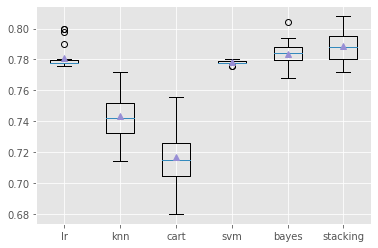

In [ ]:
# compare ensemble to each baseline classifier
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
from matplotlib import pyplot
 
# get the dataset
def get_dataset():
	(X,y) = (new_df[new_df.columns[:-1]].values, new_df[new_df.columns[-1]].values)  

	return X, y
 
# get a stacking ensemble of models
def get_stacking():
	# define the base models
	level0 = list()
	level0.append(('lr', LogisticRegression()))
	level0.append(('knn', KNeighborsClassifier()))
	level0.append(('cart', DecisionTreeClassifier()))
	level0.append(('svm', SVC()))
	level0.append(('bayes', GaussianNB()))
	# define meta learner model
	level1 = LogisticRegression()
	# define the stacking ensemble
	model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
	return model
 
# get a list of models to evaluate
def get_models():
	models = dict()
	models['lr'] = LogisticRegression()
	models['knn'] = KNeighborsClassifier()
	models['cart'] = DecisionTreeClassifier()
	models['svm'] = SVC()
	models['bayes'] = GaussianNB()
	models['stacking'] = get_stacking()
	return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores
 
# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()